In [ ]:
from jax import grad, jit, vmap, jacfwd
from functools import partial
import jax
import jax.numpy as jnp
import numpy as np
import numpy.matlib

import sklearn
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
from scipy.spatial.distance import pdist, squareform
from matplotlib import cm
import time

np.random.seed(seed=236)

@partial(jit, static_argnums=(3))
def RadFunc(X, Y, bw, ss):
    dim = len(X)
    if ss==1: #use isotropic covariance with gaussian or erf
      #square_dist = jnp.sum((X - Y)**2)
      #r=jnp.sqrt(square_dist)

      ##Gaussian Kernel - When deriving bw and cov matrix from gm model this is the only option
      #norml=jnp.sqrt((2*np.pi*bw**2)**dim)
      #rf=(1./norml)*jnp.exp(-0.5 * square_dist / bw**2)

      ##Poly Kernel
      innprod=X.T @ Y
      a=0.1
      #rf=innprod + (a*innprod+1)**2 + (a*innprod +1)**3 + (a*innprod +1)**4 + (a*innprod +1)**5
      rf= (a*innprod + 1)**4
      ##Erf potential
      #rf=r*jax.lax.erf(r/bw) +(bw/jnp.sqrt(jnp.pi))*jnp.exp(-square_dist/(bw**2))

      ##Inverse multiquadric
      #rf=1/jnp.sqrt(1+(bw*r)**2)

    else: #use unisotropic erf
      aux=X-Y
      innprod= aux.T @ jnp.linalg.solve(bw, aux)
      #normlize=jnp.sqrt(jnp.linalg.det(bw))*(jnp.sqrt(2*jnp.pi)**dim)
      #rf=jnp.exp(-0.5*innprod)/normlize
      r=jnp.sqrt(innprod)
      #rf=r*jax.lax.erf(r/bw) +(bw/jnp.sqrt(jnp.pi))*jnp.exp(-square_dist/(bw**2))
      rf=r*jax.lax.erf(r) +(1/jnp.sqrt(jnp.pi))*jnp.exp(-innprod)

    return rf



# define vectorized kernel, gradient and Jacobian
Kvmap = jit(vmap(RadFunc, in_axes=(0, None, None, None)), static_argnums=3)
#vect a second time wrt the centers and  bws
Kvmapctr = jit(vmap(Kvmap, in_axes=(None, 0, 0, None)), static_argnums=3)#return a NxNctr

#grad_Kvmap = vmap(grad(RadFunc, argnums=(0)), in_axes=(0, None, None))
gradK      = jit(grad(RadFunc, argnums=(0)), static_argnums=3)#return a 1xd vector
Jac_gradK  = jit(jacfwd(gradK), static_argnums=3) #return dxd matrix
grad_Kvmap = jit(vmap(gradK, in_axes=(0, None, None, None)), static_argnums=3)#return a Nxd vector

#vect a second time wrt the second argument and  bws
grad_Kvmap2 = jit(vmap(grad_Kvmap, in_axes=(None, 0, 0, None), out_axes=(2)), static_argnums=3)#return a NxdxNctr tensor


@partial(jit, static_argnums=(5))
def RHS(X,Xcurr,Xtarg,bw,bwtar,ss):
  #RHS to move the points X

  aux1=jnp.mean(grad_Kvmap2(X,Xcurr,bw,ss),2)
  aux2=jnp.mean(grad_Kvmap2(X,Xtarg,bwtar,ss),2)
  out=aux1-aux2

  return out.T



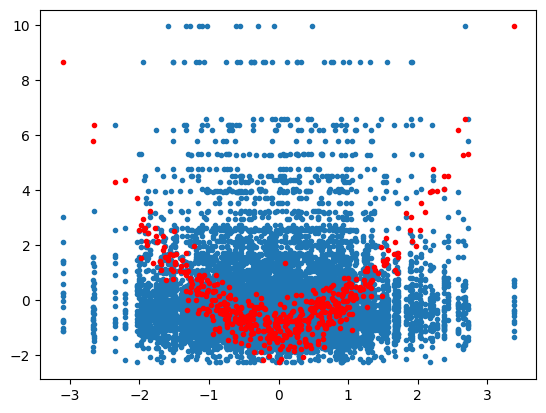

In [ ]:

# define  dataset
N = 500
dim = 2

#Joint
Zjoint=np.zeros([N,dim])
for pt in range(N):
  Zjoint[pt,0]=np.random.randn()
  Zjoint[pt,1]=0.5*np.random.randn()+Zjoint[pt,0]**2 -1

#Product measure
c1=np.zeros(N**2)
c2=np.zeros(N**2)
for k in range(N):
    c1[N*k:N+N*k]=Zjoint[k,0]*np.ones(N)
    c2[N*k:N+N*k]=Zjoint[:,1]
Zproductaux=np.stack((c1,c2),axis=1)



##The map is from product to joint measure
#kde_joint = stats.gaussian_kde(Zjoint.T)

#undersample the joint measure
M=20*N
Zproduct=Zproductaux[np.random.choice(N**2, size=M, replace=False, p=None),:]


## define KDE for target
#kde_current = stats.gaussian_kde(Zproduct.T)

plt.plot(Zproduct[:,0], Zproduct[:,1], '.', label='product')
plt.plot(Zjoint[:,0], Zjoint[:,1], '.r', label='joint')

###plt.savefig("Samples.pdf")
###files.download("/home/giulio/Dropbox/Talks/Abu-Dhabi/Samples.pdf")
###plt.savefig(f"{images_dir}/Samples.pdf")


LM=True #Lagrangia Markers
if LM:
#Passive Lagrangian markers
  Mlm=100000; ystr_lm=1 #to estimate rho(x|ystr_lm)
  Zlm=np.zeros((Mlm,2))
  Zlm[:,0]=np.random.randn(Mlm)
  Zlm[:,1]=np.ones(Mlm)*ystr_lm
  Zlm_start=Zlm

#If SGD true, then only considering Msub, Nsub points
#at each iteration step
SGD=False
Msub=int(M/5); Nsub=int(N/4)

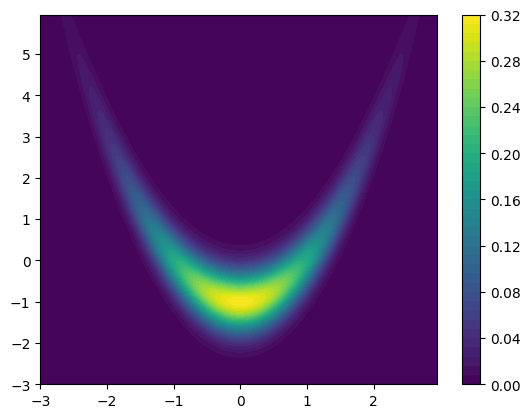

In [ ]:
def pdfjoint(x,y):
  f1=np.exp(-0.5*x**2)/np.sqrt(2*np.pi)
  sig2=0.5**2
  mu=x**2-1
  f2=np.exp(-((y-mu)**2)/(2*sig2))/np.sqrt(2*sig2*np.pi)
  return f1*f2
xg = np.arange(-3, 3, 0.05)
yg = np.arange(-3, 6, 0.05)
xxg, yyg = np.meshgrid(xg, yg, sparse=True)
zpdf = pdfjoint(xxg,yyg)
hhh = plt.contourf(xg,yg,zpdf,50)
plt.colorbar()
###plt.savefig(f"{images_dir}/Contour.pdf")


In [ ]:
# set parametes
maxIter = 3000  # number of flow iterations
epsilon = 0.5  # scaling factor for learning rate
lam=10000 #to define the triangular cost
numpar=1; numobs=1
aux_param=jnp.ones(numpar)
aux_obs=(1/lam)*jnp.ones(numobs)
lamMat=jnp.diag(np.hstack((aux_param,aux_obs)),0)


In [ ]:
beta_mon=np.array([])
bw_mon=np.array([])
gr_mon=np.array([])
Jtot=np.ones(M)


In [ ]:
#Main Loop
now = time.time()
Zinitial=jnp.array(Zproduct)
Zcurrent=jnp.array(Zproduct)
ss=1

h=0.1; itr=0
notdone=True
while notdone:

  if itr % np.floor(maxIter/10) == 0:
      print('iteration=', itr)

  if SGD: #Stoch Gradient Descent
    Zcr=Zcurrent[np.random.choice(M, size=Msub, replace=False, p=None),:]
    Zjnt=Zjoint[np.random.choice(N, size=Nsub, replace=False, p=None),:]
  else:
    Msub=M; Nsub=N
    Zcr=Zcurrent
    Zjnt=Zjoint

  #Changing bandwidth along the way
  mm=(maxIter/2); msig=(maxIter/10)
  fc=1 + 0.5/(1+jnp.exp((itr-mm)/msig))
  bw=fc*jnp.ones(Msub); bwtar=fc*jnp.ones(Nsub);

  G=RHS(Zcurrent,Zcr,Zjnt,bw,bwtar,ss)
  Glam=jnp.matmul(lamMat,G).T


  if jnp.isnan(G).any():
    print('RHS none')
    print('itr',itr)
    break
  Zcurrent=Zcurrent-h*Glam
  gr_norm=jnp.linalg.norm(Glam)
  gr_mon=jnp.append(gr_mon,gr_norm)
  if gr_norm<10**-8 or itr==maxIter:
    notdone=False

  if LM:
      G_lm=RHS(Zlm,Zcr,Zjnt,bw,bwtar,ss)
      Glam_lm=jnp.matmul(lamMat,G_lm).T
      Zlm = Zlm - h*Glam_lm


  itr=itr+1

print('Execution time =',time.time() - now)


iteration= 0
iteration= 300
iteration= 600
iteration= 900
iteration= 1200
iteration= 1500
iteration= 1800
iteration= 2100
iteration= 2400
iteration= 2700
iteration= 3000
Execution time = 532.0092236995697


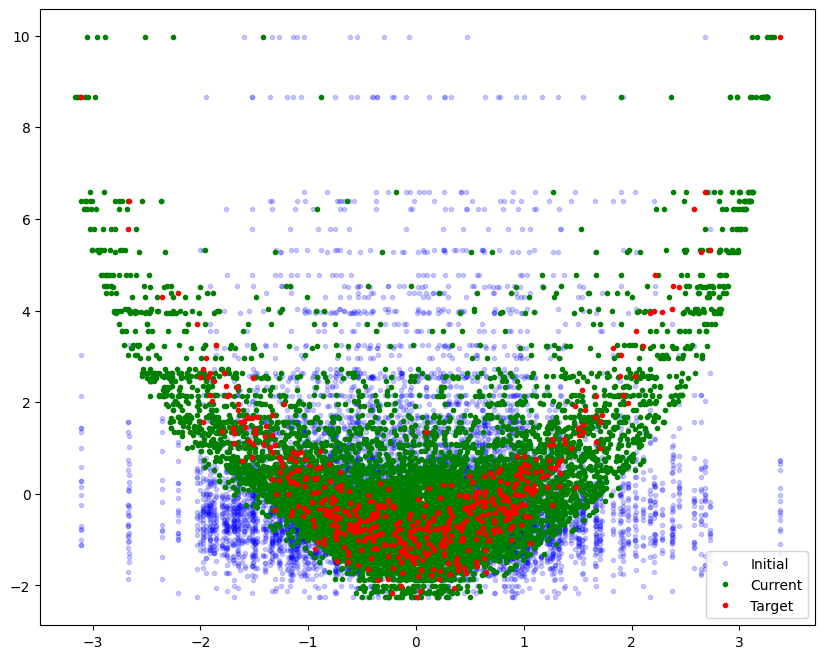

In [ ]:
# plot points
plt.figure(figsize=(10,8))
plt.plot(Zinitial[:,0], Zinitial[:,1], '.b', label='Initial',alpha=0.2)
plt.plot(Zcurrent[:,0], Zcurrent[:,1], '.g', label='Current',alpha=1)
plt.plot(Zjoint[:,0], Zjoint[:,1], '.r', label='Target',alpha=1)
plt.legend()
#plt.show()
###plt.savefig(f"{images_dir}/MappedSamples.pdf")


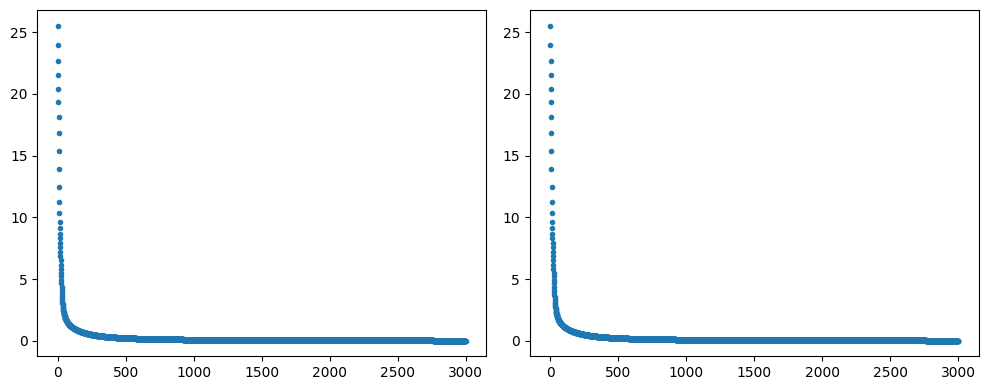

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(gr_mon,'.')
ax2.plot(gr_mon,'.')
#ax3.plot(bwnorms,'.')

plt.tight_layout()

Mean movement in the y direction 7.123238e-05


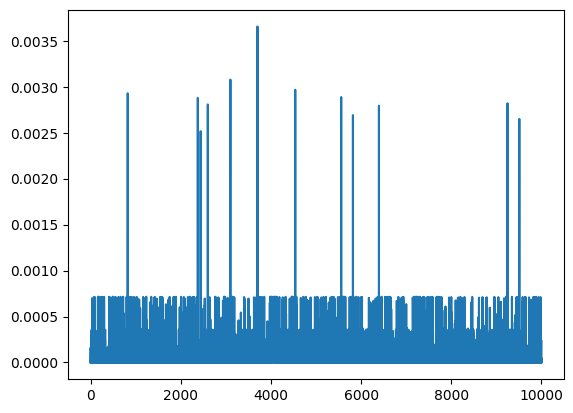

In [ ]:
mm=np.abs(Zcurrent[:,1]-Zinitial[:,1])
plt.plot(mm)
print('Mean movement in the y direction',np.mean(mm))


In [ ]:
import scipy

In [ ]:
#Check the estimated conditional density rho(x|ystr)
ystr=ystr_lm; dy=0.05
#Choose one of the ystr in the training set for which we computed the map
indstr=np.argmin(np.abs(Zinitial[:,1]-ystr))

print('ystar = ',ystr)
#kernel density estimation using Zcurrent
#Select all the mapped point in ystr-dy and ystr+dy
indstr= (Zcurrent[:,1] > ystr - dy ) & (Zcurrent[:,1] < ystr + dy)
spt= Zcurrent[indstr,:] #sample points
kernel=scipy.stats.gaussian_kde(spt[:,0])#, bw_method=None, weights=None)

#grid in x space on where to estimate the densities
#xgrid=np.linspace(np.min(spt[:,0]),np.max(spt[:,0]),500)
xgrid=np.linspace(-3,3,500)
kdexgrd=kernel(xgrid)

#kde using raw data (for comparison)
#Select all the mapped point in ystr-dy and ystr+dy
indstr_raw= (Zjoint[:,1] > ystr - 2*dy ) & (Zjoint[:,1] < ystr + 2*dy)
spt_raw= Zjoint[indstr_raw,:] #sample points
kernel_raw=scipy.stats.gaussian_kde(spt_raw[:,0])#, bw_method=None, weights=None)
kde_raw=kernel_raw(xgrid)

#Compute theoretical conditional density (yet another comparison)
def pycx(x,ystr):
  s=0.5; s2=s**2;
  m=ystr-(x**2-1)
  return np.exp(-(m**2)/(2*s2))/np.sqrt(2*np.pi*s2)

def px(x):
  return np.exp(-(x**2)/(2))/np.sqrt(2*np.pi)

def pxcy(x,ystr):
  return pycx(x,ystr)*px(x)

nfact=scipy.integrate.quad(pxcy,-np.inf,+np.inf,args=ystr)
truthcd=pxcy(xgrid,ystr)/nfact[0]




ystar =  1


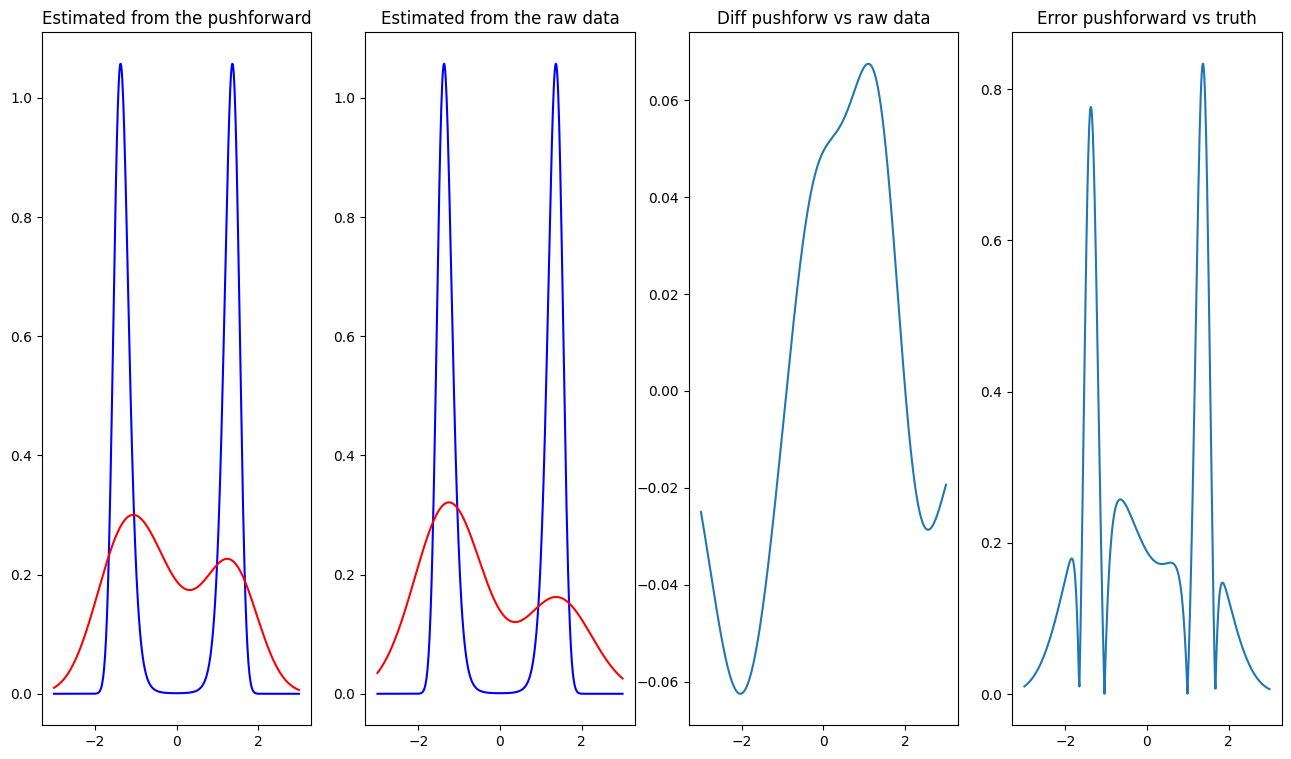

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(16,9))

axs[0].plot(xgrid,truthcd,'b') #true cond density rho(x|ystr)
axs[0].plot(xgrid,kdexgrd,'r')
axs[0].title.set_text('Estimated from the pushforward')

axs[1].plot(xgrid,truthcd,'b')
axs[1].plot(xgrid,kde_raw,'r')
axs[1].title.set_text('Estimated from the raw data')

axs[2].plot(xgrid,kdexgrd-kde_raw)
axs[2].title.set_text('Diff pushforw vs raw data')

axs[3].plot(xgrid,np.abs(kdexgrd-truthcd))
axs[3].title.set_text('Error pushforward vs truth')

###plt.savefig(f"{images_dir}/CondDens_Raw.pdf")



In [ ]:
# #Now interpolate the map and use this approach as a generative model for the posterior rho(x|ystr) given samples from the prior rho(x)
# #we need to reduce the dy in order to avoid taking points with the same x. Building an interpolation will be impossibile otherwise
# indstr_map= (Zproduct[:,1] > ystr - dy ) & (Zproduct[:,1] < ystr + dy)

# #Map interpolation requires not repeated, strictily increasing x
# xx=Zproduct[indstr_map,0]; yy=Zcurrent[indstr_map,0];
# idxincr=np.argsort(xx)
# xx=xx[idxincr]; yy=yy[idxincr]
# xx, indices = np.unique(xx, return_index=True)
# yy= yy[indices]
# #cs --> cubic spline interpolation
# cs=scipy.interpolate.CubicSpline(xx,yy)
# xgridcs=np.linspace(-3,3,100)

# plt.plot(xx,yy,'.');
# plt.plot(xgridcs,cs(xgridcs),'-r')
# plt.title('Map interpolation')
# plt.xlabel('Starting position')
# plt.ylabel('Mapped position')


# #now use the estimated map to generate samples
# Ngen=1000
# xgen=np.random.randn(Ngen) #generate samples from the prior
# ygen=cs(xgen) #map the prior to the conditional rho(x|ystr)
# kernel_gen=scipy.stats.gaussian_kde(ygen)#, bw_method=None, weights=None)

# fig, axs = plt.subplots(1,2,figsize=(16,9))

# axs[0].plot(xgrid,truthcd,'.b')
# axs[0].plot(xgrid,kernel_gen(xgrid),'.r')#cond estimated density using generated data
# axs[0].title.set_text('Estimated cond densities')

# axs[1].plot(xgrid,np.abs(kdexgrd-truthcd),'.b') #error using pushforward points
# axs[1].plot(xgrid,np.abs(kernel_gen(xgrid)-truthcd),'.r') #error using generated data
# axs[1].title.set_text('Errors')

In [ ]:
# #plt.plot(xx,yy,'.');
# plt.plot(xgridcs,cs(xgridcs),'-r')
# plt.title('Map at $y^{*}$')
# plt.xlabel('Starting position')
# plt.ylabel('Mapped position')
# ###plt.savefig(f"{images_dir}/Mapystr.pdf")


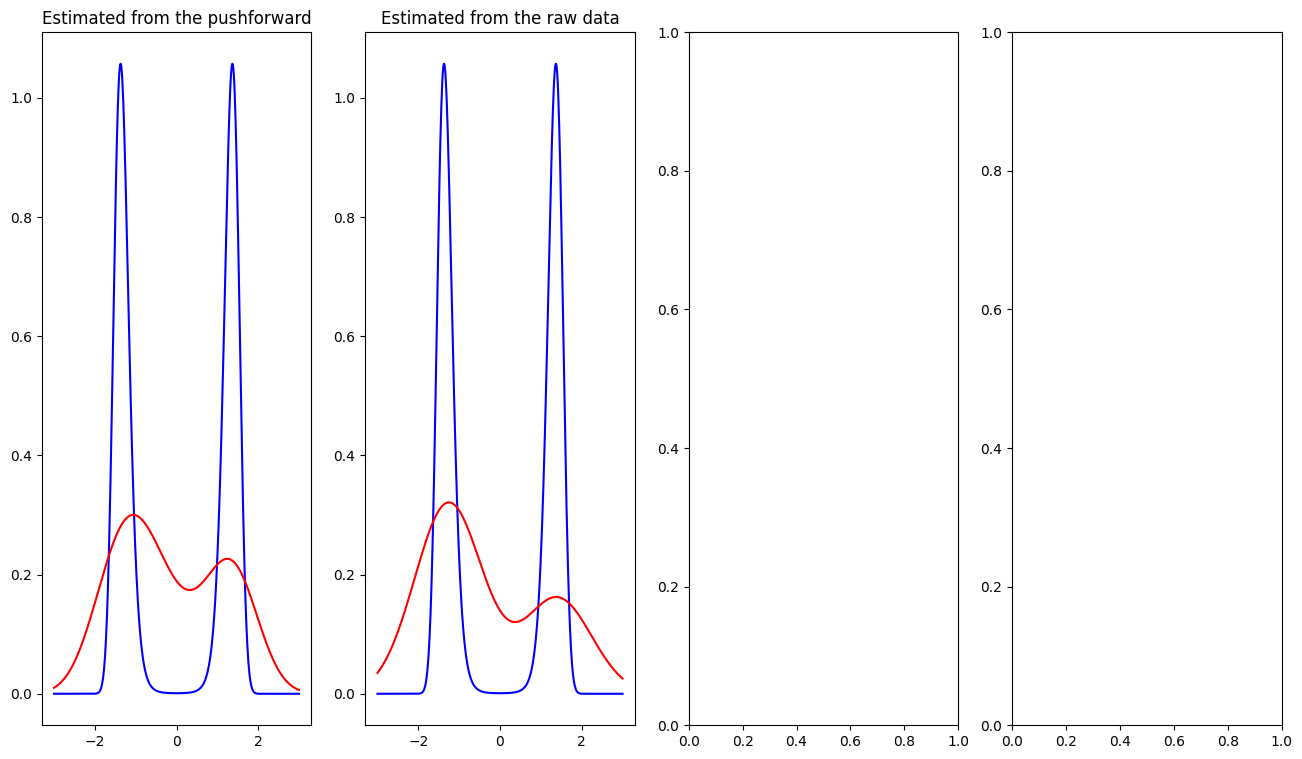

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(16,9))

axs[0].plot(xgrid,truthcd,'b') #true cond density rho(x|ystr)
axs[0].plot(xgrid,kdexgrd,'r')
axs[0].title.set_text('Estimated from the pushforward')

axs[1].plot(xgrid,truthcd,'b')
axs[1].plot(xgrid,kde_raw,'r')
axs[1].title.set_text('Estimated from the raw data')


# axs[2].plot(xgrid,truthcd,'b')
# axs[2].plot(xgrid,kernel_gen(xgrid),'r')#cond estimated density using generated data
# axs[2].title.set_text('Estimated generative')


# axs[3].plot(xgrid,np.abs(kdexgrd-truthcd),'b') #error using pushforward points
# axs[3].plot(xgrid,np.abs(kernel_gen(xgrid)-truthcd),'r') #error using generated data
# axs[3].title.set_text('Errors')
# ###plt.savefig(f"{images_dir}/CondDens.pdf")


In [ ]:
# #Estimate from Gaussian Mixture
# ptgm=np.zeros((500,2));ptgm[:,0]=xgrid; ptgm[:,1]=ystr*np.ones(500);
# gmpred=np.exp(gm.score_samples(ptgm))
# normfact=-np.trapz(xgrid,gmpred)

# fig, axs = plt.subplots(1,2,figsize=(16,9))

# axs[0].plot(xgrid,truthcd,'.b')
# axs[0].plot(xgrid,gmpred/normfact,'.r')#from GM
# axs[0].title.set_text('Estimated cond densities from GM')

# axs[1].plot(xgrid,np.abs(gmpred/normfact-truthcd),'.b') #error using pushforward points
# axs[1].title.set_text('Errors')



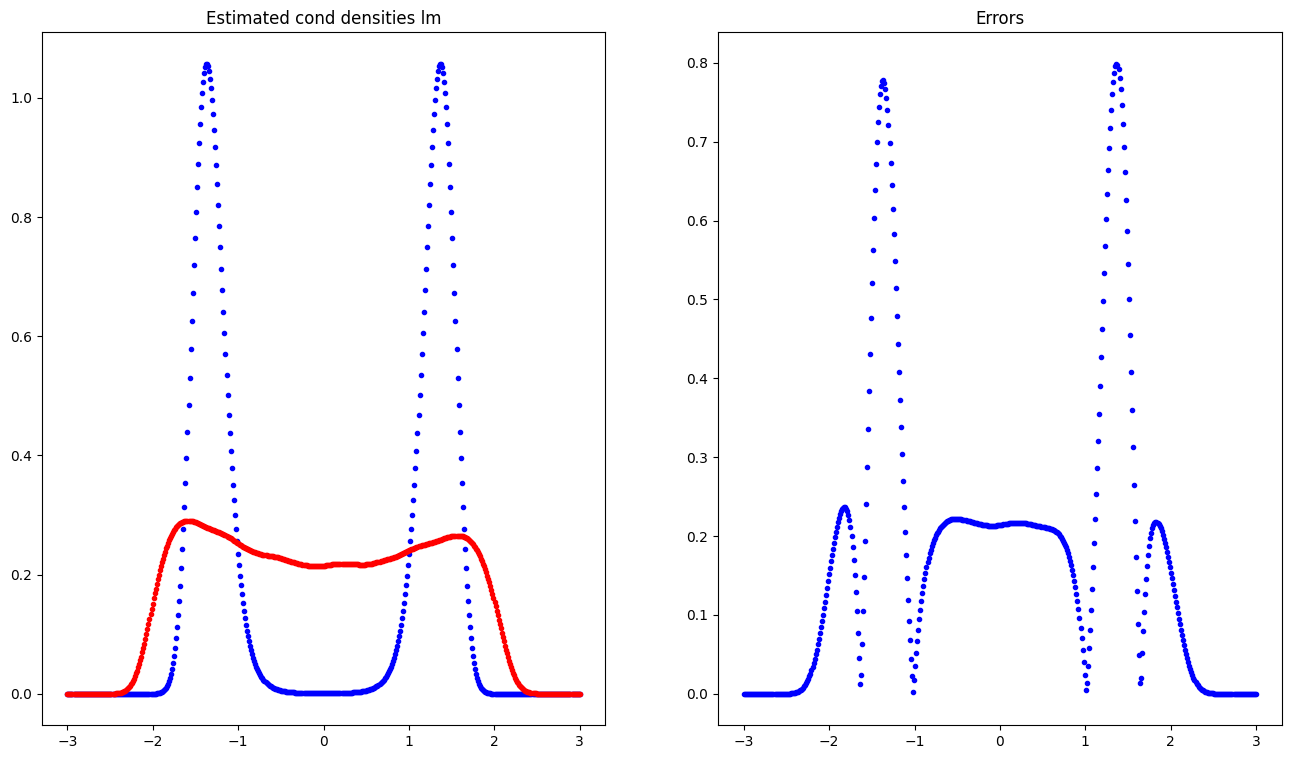

In [ ]:
#Estimate with Lagrangia markers
if LM:
  kernel_lm=scipy.stats.gaussian_kde(Zlm[:,0])#, bw_method=None, weights=None)

  fig, axs = plt.subplots(1,2,figsize=(16,9))

  axs[0].plot(xgrid,truthcd,'.b')
  axs[0].plot(xgrid,kernel_lm(xgrid),'.r')#cond estimated density using generated data
  axs[0].title.set_text('Estimated cond densities lm')

  axs[1].plot(xgrid,np.abs(kernel_lm(xgrid)-truthcd),'.b') #error using pushforward Lagrangia Markers
  #axs[1].plot(xgrid,np.abs(kernel_gen(xgrid)-truthcd),'.r') #error using cs map
  axs[1].title.set_text('Errors')

In [ ]:
# if LM:
#   fig, axs = plt.subplots(1,2,figsize=(16,9))

#   axs[0].hist(Zlm_start)
#   axs[1].hist(Zlm)

In [ ]:
print(M)
print(Msub)
print(N)
print(Nsub)

In [ ]:
215*((1+0.03)**30)

521.8614313057774

In [ ]:
905*12*30


325800